In [1]:
import pyvista as pv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections as mc
import torch
import os
import time
from network import DMM_Decoder
from loss_utils import batched_chamfer_distance

In [2]:

def read_points(filename, params):
    lines = open(filename, 'r').readlines()
    points = np.zeros([params["point_number"], 2], dtype=float)
    for i, line in enumerate(lines[params["point_start_line"]:params["point_end_line"]]):
        line = line.strip().split('\t')
        points[i, 0] = float(line[0])
        points[i, 1] = float(line[1])
    return points

def read_faces(filename, params):
    lines = open(filename, 'r').readlines()
    faces = np.zeros([params["face_number"], 3], dtype=int)
    for i, line in enumerate(lines[params["face_start_line"]:params["face_end_line"]]):
        line = line.strip().split('\t')
        faces[i, 0] = int(line[1])
        faces[i, 1] = int(line[2])
        faces[i, 2] = int(line[3])
    return faces

def read_id_list(filename, start_line, end_line):
    lines = open(filename, 'r').readlines()
    id_list = []
    for line in lines[start_line:end_line]:
        line = line.strip().split('\t')
        id_list.append([int(line[1]), int(line[2])])
    return np.array(id_list, dtype=int)

def read_wall_id_list(filename, params):
    return read_id_list(filename, params["wall_start_line"], params["wall_end_line"])

def read_first_layer_id_list(filename, params, const=0):
    return read_id_list(filename, params["wall_start_line"], params["wall_end_line"]) + 1 - const

def read_inlet_id_list(filename, params):
    return read_id_list(filename, params["inlet_start_line"], params["inlet_end_line"])

def read_outlet_id_list(filename, params):
    return read_id_list(filename, params["outlet_start_line"], params["outlet_end_line"])

def read_symmetry_id_list(filename, params):
    return read_id_list(filename, params["symmetry_start_line"], params["symmetry_end_line"])

def read_farfield_id_list(filename, params):
    return read_id_list(filename, params["farfield_start_line"], params["farfield_end_line"])


In [3]:
class Template_Mesh():
    def __init__(self, cached_mesh_key = 'deformed_area'):
        self.cached_mesh_key = cached_mesh_key
    
    def init_mesh(self):
        pass
    
    def write_to_polyMesh(self):
        pass
    
    def write_to_openfoam_probe_file(self):
        pass
    
    def write_to_su2Mesh(self):
        pass
    
    def get_surface_edges_and_faces(self):
        if hasattr(self, 'surface_edge_index') == False: 
            unique_contour_id = self.contour_id_list.flatten().unique()
            is_surface_edge = sum(
                [self.edge_index[:,0] == _ for _ in unique_contour_id] +\
                [self.edge_index[:,1] == _ for _ in unique_contour_id]
            ) > 1 # 1=2-1                                   # [num_e]
            self.surface_edge_index = self.edge_index[is_surface_edge, :]
            
        if hasattr(self, 'surface_edge_faces') == False:
            num_face_edges = self.faces.shape[1]
            unique_contour_id = self.contour_id_list.flatten().unique()
            is_surface_face = 0
            for i in range(self.faces.shape[1]):
                is_surface_face += sum([self.faces[:,i] == _ for _ in unique_contour_id])
            is_surface_face = is_surface_face > (num_face_edges - 1)
            self.surface_faces = self.faces[is_surface_face, :]
            
        return self.surface_edge_index, self.surface_faces
    
    @staticmethod
    def get_connected_faces(query_v_id_list, faces):
        queried_faces_list = []
        for query_v_id in query_v_id_list:
            is_queried_face = 0
            for i in range(faces.shape[1]):
                is_queried_face += (faces[:,i] == query_v_id)
            is_queried_face = is_queried_face > 0
            queried_faces_list.append(faces[is_queried_face, :])
        return queried_faces_list
    
    @staticmethod
    def get_connected_edge_index(query_v_id_list, edge_index):
        queried_edge_list = []
        for query_v_id in query_v_id_list:
            is_queried_edge = 0
            for i in range(edge_index.shape[1]):
                is_queried_edge += (edge_index[:,i] == query_v_id)
            is_queried_edge = is_queried_edge > 0
            queried_edge_list.append(edge_index[is_queried_edge, :])
        return queried_edge_list
    
    def parse_mesh_dict(self, to_tensor=False):
        # self.cached_mesh_key = 'deformed_area' by default
        self.v = self.CFD_mesh[self.cached_mesh_key]['points']               # [num_v, v_dim]
        self.v_movable_mask = self.CFD_mesh[self.cached_mesh_key]['movable_mask']  # True for movable, False for fixed, [num_v, v_dim]
        self.edge_set = self.CFD_mesh[self.cached_mesh_key]['edge_set']
        self.edge_index = self.edge_set.get_edge()                   # [num_e, 2]
        self.faces = self.CFD_mesh[self.cached_mesh_key]['faces']            # [num_f, <unknown>]
        if hasattr(self.edge_set, 'neighbor'):
            delattr(self.edge_set, 'neighbor')
        self.num_vertices = self.v.shape[0]
        self.contour_id_list = self.CFD_mesh[self.cached_mesh_key]['wall_id_list']
        self.first_layer_id_list = self.CFD_mesh[self.cached_mesh_key]['first_layer_id_list']
        if hasattr(self.CFD_mesh[self.cached_mesh_key], 'boundary_contour_id_list'):
            self.boundary_id_list = self.CFD_mesh[self.cached_mesh_key]['boundary_contour_id_list']
        else:
            # return True if at least one False appears in any movable_mask
            # return False for totally movable vertices
            self.boundary_id_list = self.v_movable_mask.sum(axis=1) < self.v_movable_mask.shape[1]  
        
        if to_tensor == True:
            import torch
            self.v = torch.tensor(self.v)
            self.v_movable_mask = torch.tensor(self.v_movable_mask)
            self.edge_index = torch.tensor(self.edge_index)
            self.faces = torch.tensor(self.faces)
            self.contour_id_list = torch.tensor(self.contour_id_list)
            self.boundary_id_list = torch.tensor(self.boundary_id_list)
            self.first_layer_id_list = torch.tensor(self.first_layer_id_list)
        
        return self.v, self.v_movable_mask, \
             self.edge_set, self.edge_index, \
             self.faces, \
             self.num_vertices, \
             self.contour_id_list, self.boundary_id_list, self.first_layer_id_list

class Edge_Set():
    def __init__(self):
        self.edge = []
    
    def add_edge(self, p1, p2):
        if (p1 is None) or (p2 is None):
            return
        self.edge.append(np.array([ min(p1,p2), max(p1,p2) ], dtype=int))
        
    def get_edge(self):
        return np.unique(np.array(list(self.edge)), axis=0)
            
    def get_point_neighbor(self):
        edges = self.get_edge()
        num_v = edges.max() + 1
        neighbor_list = [set() for _ in range(num_v)]
        max_neighbor_num = 0
        for i in range(edges.shape[0]):
            neighbor_list[ edges[i,0] ].add(edges[i,1])
            neighbor_list[ edges[i,1] ].add(edges[i,0])
            max_neighbor_num = len(neighbor_list[ edges[i,0] ]) if len(neighbor_list[edges[i,0]]) > max_neighbor_num else max_neighbor_num
            max_neighbor_num = len(neighbor_list[ edges[i,1] ]) if len(neighbor_list[edges[i,1]]) > max_neighbor_num else max_neighbor_num
        self.neighbor = np.zeros([num_v, max_neighbor_num]) - 1     # -1 for empty element
        for i in range(num_v):
            self.neighbor[i, :len(neighbor_list[i])] = np.array(list(neighbor_list[i]))
        return self.neighbor
            
    def __len__(self):
        return len(self.edge)


class Flat_Plate(Template_Mesh):
    def __init__(self, params, raw_file, cache_name=None, su2Mesh_dir=None):
        super().__init__()
        self.cache_name = cache_name
        self.su2Mesh_dir = su2Mesh_dir
        self.raw_file = raw_file
        self.params = params 

    def init_mesh(self, use_cache=True):
        if self.cache_name is None:
            self.cache_name = './init_mesh_cache.pymesh'
        
        
        points = read_points(self.raw_file, self.params)
        faces = read_faces(self.raw_file, self.params)
        edge_set = Edge_Set()
        for i in range(faces.shape[0]):
            for j in range(faces.shape[1]):
                edge_set.add_edge(faces[i,j], faces[i,j-1])
        wall_id_list = read_wall_id_list(self.raw_file, self.params)
        inlet_id_list = read_inlet_id_list(self.raw_file, self.params)
        outlet_id_list = read_outlet_id_list(self.raw_file, self.params)
        symmetry_id_list = read_symmetry_id_list(self.raw_file, self.params)
        farfield_id_list = read_farfield_id_list(self.raw_file, self.params)
        boundary_id_list = np.concatenate((wall_id_list, inlet_id_list, outlet_id_list, symmetry_id_list, farfield_id_list))
        if self.raw_file=="mesh_flatplate_65x65.su2":
            first_layer_id_list = read_first_layer_id_list(self.raw_file, self.params, const=2)
        else:
            first_layer_id_list = read_first_layer_id_list(self.raw_file, self.params)
            
        
        movable_mask = np.ones(points.shape).astype(bool)
        movable_mask[np.unique(boundary_id_list.flatten()), :] = 0
        
        self.CFD_mesh = dict()
        self.CFD_mesh['deformed_area'] = dict()
        self.CFD_mesh['deformed_area']['points'] = points
        self.CFD_mesh['deformed_area']['faces'] = faces
        self.CFD_mesh['deformed_area']['edge_set'] = edge_set
        self.CFD_mesh['deformed_area']['wall_id_list'] = wall_id_list
        self.CFD_mesh['deformed_area']['boundary_contour_id_list'] = boundary_id_list
        self.CFD_mesh['deformed_area']['first_layer_id_list'] = first_layer_id_list
        self.CFD_mesh['deformed_area']['movable_mask'] = movable_mask
        
        torch.save(self.CFD_mesh, self.cache_name)
        return self.CFD_mesh
    
    def read_from_su2Mesh(self, mesh_file, to_tensor=False):
        if self.su2Mesh_dir is None:
            raw_file = mesh_file
        else:
            raw_file = os.path.join(self.su2Mesh_dir, mesh_file)
        
        with open(raw_file, 'r') as f:
            lines = f.readlines()

        points = []
        for line in lines[self.params["point_start_line"]:self.params["point_end_line"]]:
            parts = line.split()
            if len(parts) == 3:
                x, y, _ = map(float, parts)
                points.append([x, y])
        
        if to_tensor:
            import torch
            return torch.tensor(points)
        return np.array(points)
        
    def write_to_su2Mesh(self, points, output_point_file):
        assert(points.ndim == 2)
        assert(points.shape[0] == self.params["point_number"])
        
        if self.su2Mesh_dir is None:
            
            raw_file = self.raw_file
        else:
            
            raw_file = os.path.join(self.su2Mesh_dir, self.raw_file)
        
        with open(raw_file, 'r') as f:
            lines = f.readlines()
        with open(output_point_file, 'w') as f:
            for i in range(self.params["point_start_line"]):
                f.write(lines[i])
            for i in range(points.shape[0]):
                f.write('\t\t%.12f\t%.12f\t%.12f\n'%(points[i,0], points[i,1], 0.))
            for i in range(self.params["point_end_line"], len(lines)):
                f.write(lines[i])
        return output_point_file

In [4]:
def plot_airfoil_2d_details(vertices, edge_index, airfoil_pts, prefix, first_layer_pts=None, visualize_full=True, visualize_zoom=True, coarse=False, alpha=1):
    v_np = vertices.data.cpu().numpy().squeeze()
    vx_np = v_np[:,0]
    vy_np = v_np[:,1]
    edge_index_np = edge_index.data.cpu().numpy().squeeze()
    if airfoil_pts is not None:
        airfoil_pts = airfoil_pts.squeeze()
        airfoil_x_np = airfoil_pts[:,0].data.cpu().numpy().squeeze()
        airfoil_y_np = airfoil_pts[:,1].data.cpu().numpy().squeeze()
    
    # matplotlib list of colors: https://matplotlib.org/stable/gallery/color/named_colors.html
    fig = plt.gcf()
    fig.set_size_inches(12,8)
    if airfoil_pts is not None:
        plt.scatter(airfoil_x_np, airfoil_y_np, s=15, color='red', label="Wall")

    if first_layer_pts is not None:
        first_layer_pts = first_layer_pts.squeeze()
        first_layer_x_np = first_layer_pts[:,0].data.cpu().numpy().squeeze()
        first__layer_y_np = first_layer_pts[:,1].data.cpu().numpy().squeeze()
    if first_layer_pts is not None:
        plt.scatter(first_layer_x_np, first__layer_y_np, s=15, color='blue', label="First layer")

    # plot mesh
    plt.scatter(vx_np, vy_np, s=0.05, color='dimgrey')
    plt.grid()
    plt.legend(prop={"size": 20})
    edges = np.stack([vx_np[edge_index_np[:,0]], vy_np[edge_index_np[:,0]], vx_np[edge_index_np[:,1]], vy_np[edge_index_np[:,1]]], axis=1)
    edges = edges.reshape(-1, 2, 2)
    lc = mc.LineCollection(edges, colors='silver', linewidths=0.25)
    axes = plt.gca()
    axes.add_collection(lc)

    # Set font size for axis ticks and labels
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    if visualize_full == True:
        plt.savefig('{}_full_size.png'.format(prefix), dpi=150)
    
    if visualize_zoom == True:
        fig = plt.gcf()
        fig.set_size_inches(12, 8)
        axes = plt.gca()
        
        if coarse:
            axes.set_xlim([-0.01,0.05])
            axes.set_ylim([-alpha*0.0002,0.001*alpha])
        else:
            axes.set_xlim([-0.01,0.05]) #([-0.05,1.075]) 
            axes.set_ylim([-alpha*0.000002,0.00001*alpha]) #([-0.25,0.25])
        plt.savefig('{}_zoom.png'.format(prefix), dpi=150)
    plt.close()


def deform_mesh(v, factor=100):
    v_ = torch.clone(v)
    vy = v[:, 1]
    #ran =  np.outer(np.ones(3), np.arange(385)).flatten() # VERSION FOR COLUMNS
    #ran = np.outer(np.ones(545), np.arange(5)).flatten()
    #v_[:, 1] = min(vy)+(max(vy)-min(vy))*(64-ran)/max(ran)
    v_[:, 1] = factor*vy
    return v_


In [59]:
counter = 0
def reg_loss(v, delta_v):
    v_dim = v.shape[-1]
    delta_v_dim = delta_v.shape[-1]
    global counter
    counter_1 = counter % delta_v_dim
    counter_2 = int((counter % (v_dim*delta_v_dim)) / delta_v_dim)
    counter_3 = int((counter % (v_dim*v_dim*delta_v_dim)) / (v_dim*delta_v_dim))

    grad_outputs = torch.ones(delta_v.shape[:-1], device=delta_v.device)
    dDv_dv  = torch.autograd.grad(delta_v[:,:,counter_1], v, grad_outputs=grad_outputs, retain_graph=True, create_graph=True)[0]
    
    grad_outputs = torch.ones(v.shape[:-1], device=delta_v.device)
    d2Dv_dv2 = torch.autograd.grad(dDv_dv[:,:,counter_2], v, grad_outputs, retain_graph=True,create_graph=True)[0][:,:,counter_3]
    counter += 1
    
    loss = - (d2Dv_dv2 ** 2).mean()
    
    if counter_2 != counter_3:
        loss *= 0.5
    return loss.abs()

def do_minimization_iter(
            decoder,
            v,
            wall_id_list,
            boundary_id_list,
            first_layer_id_list,
            optimizer,
            regular_sampling_ratio,
            target_mesh = None,
            target_first_layer = None
           ):
    batch_size = target_mesh.shape[0] if target_mesh is not None else 1
    decoder.train()
    
    v_wall = v[wall_id_list].repeat(batch_size, 1, 1)
    v_boundary = v[boundary_id_list].repeat(batch_size, 1, 1)
    mask = torch.ones_like(v[:, 0], dtype=torch.bool)
    mask[boundary_id_list] = False
    v_inside = v[mask]
    

    mask_wall = torch.zeros_like(v[:, 0], dtype=torch.bool)
    mask_wall[wall_id_list] = True

    num_sampled = int(regular_sampling_ratio * v.shape[0])
    rand_id = torch.randint(low=0, high=v.shape[0], device=v.device, size=[num_sampled])
    combined_id = torch.cat([boundary_id_list, rand_id])
    uniques, counts = combined_id.unique(return_counts=True)
    rand_id = uniques[counts == 1]
    v_sampled = v[rand_id].repeat(batch_size, 1, 1)
    
    #v_sampled = v_inside.repeat(batch_size, 1, 1)
    v_sampled.requires_grad = True

    mask_first_layer = torch.zeros_like(v[:, 0], dtype=torch.bool)
    mask_first_layer[first_layer_id_list] = True
    v_first_layer = v[mask_first_layer].repeat(batch_size, 1, 1)

    #target_mesh_sampled = target_mesh[:, mask, :]#[:, rand_id, :]
    #v_sampled_difference = v_sampled-target_mesh_sampled
    #print(v_wall.shape)
    #print(v_first_layer.shape)
    #print(v_boundary.shape)
    #print(v_sampled.shape)
    v_ = torch.cat([v_sampled, v_first_layer, v_boundary, v_wall], dim=1)
    #print(v_.shape)
    #v_ = v.repeat(batch_size, 1, 1)
    
    delta = decoder(v_.float())
    #print(delta.shape)
    delta_sampled = delta[:, :v_sampled.shape[1], :]
    delta_first_layer = delta[:, v_sampled.shape[1]:(v_sampled.shape[1]+v_first_layer.shape[1]), :]
    delta_wall = delta[:, (v_sampled.shape[1]+v_first_layer.shape[1]+v_boundary.shape[1]):, :]

    #delta_first_layer = delta[:, mask_first_layer, :]
    #delta_wall = delta[:, mask_wall, :]

    ## L2 loss
    if target_mesh is not None:
        loss_first_layer = (((v_first_layer+delta_first_layer-target_mesh[:, mask_first_layer, :]) ** 2).sum(dim=-1) ** 0.5).mean()
    else:
        loss_first_layer = (((v_first_layer+delta_first_layer-target_first_layer) ** 2).sum(dim=-1) ** 0.5).mean()

    loss_wall = (((delta_wall) ** 2).sum(dim=-1) ** 0.5).mean()
    
    ## L1 loss
    #loss_first_layer = ((torch.absolute((v_first_layer+delta_first_layer-target_mesh[:, mask_first_layer, :]))).sum(dim=-1)).mean()
    #loss_wall = ((torch.absolute(delta_wall)).sum(dim=-1)).mean()

    ## Log loss
    epsilon = 1e-10
    #loss_first_layer = torch.exp(torch.log(torch.max(torch.abs(v_first_layer + delta_first_layer - target_mesh[:, mask_first_layer, :]).sum(dim=-1), epsilon*torch.ones_like(v_first_layer[:, :, 0])))).mean()
    #loss_wall = torch.exp(torch.log(torch.max((torch.abs(delta_wall)).sum(dim=-1), epsilon*torch.ones_like(delta_wall[:, :, 0])))).mean()
    
    ## Log-L2 loss
    #loss_first_layer = (((torch.log(torch.max(torch.abs(v_first_layer+delta_first_layer), epsilon*torch.ones_like(v_first_layer))) - torch.log(torch.max(torch.abs(target_mesh[:, mask_first_layer, :]), epsilon*torch.ones_like(v_first_layer))))**2).sum(dim=-1)).mean()
    #loss_wall = ((torch.log(torch.max(torch.abs(delta_wall), epsilon*torch.ones_like(v_first_layer)))**2).sum(dim=-1)).mean()
    
    ## L2/L1 loss
    #loss_first_layer = ((((v_first_layer+delta_first_layer-target_mesh[:, mask_first_layer, :]) ** 2).sum(dim=-1))/torch.max(epsilon*torch.ones_like(v_first_layer[:, :, 0]), torch.abs(v_first_layer+delta_first_layer-target_mesh[:, mask_first_layer, :]).sum(dim=-1))).mean()
    #loss_wall = ((((delta_wall) ** 2).sum(dim=-1))/torch.max(epsilon*torch.ones_like(v_first_layer[:, :, 0]), torch.abs(delta_wall).sum(dim=-1))).mean()


    ## Reg loss
    loss_reg = reg_loss(v_sampled, delta_sampled)
    #loss_reg = avm_loss_full(v_sampled, delta_sampled)


    #loss_reg = torch.zeros(1)
    #loss_first_layer = torch.zeros(1)
    #loss_wall = torch.zeros(1)

    
    loss = loss_first_layer +  loss_wall + loss_reg
    loss.backward()

    #print(decoder.output_layer_delta.weight.grad[1,:].norm())


    optimizer.step()

    return delta, loss_first_layer, loss_wall, loss_reg

def training_mesh(target_mesh_, modified_mesh_, boundary_id_list, wall_id_list, first_layer_id_list, coarse=False, n_iterations=1000, modified_y_plus=None, target_y_plus=None):
    decoder = DMM_Decoder(
        v_dim=2, 
        layer_dim=[512, 512]
    )
    #print('Model info')
    #print(decoder)
    decoder.init_weights()

    mesh_fine = not coarse

    # ------------------------------------
    if mesh_fine:
        const = 5000
    else:
        const = 200
    
    if modified_y_plus is None:
        target_mesh = torch.clone(target_mesh_).unsqueeze(0)#.detach()
        target_mesh[:, :, 1] = target_mesh[:, :, 1]*const
        target_first_layer = None
    else:
        target_mesh = None
        mask_first_layer = torch.zeros_like(modified_mesh_[:, 0], dtype=torch.bool)
        mask_first_layer[first_layer_id_list.flatten().unique()] = True
        target_first_layer = modified_mesh_[mask_first_layer]
        target_first_layer[:, 1] = target_first_layer[:, 1]/modified_y_plus*const
        if target_y_plus is not None:
            target_first_layer[:, 1] = target_first_layer[:, 1]*target_y_plus

    initial_mesh = torch.clone(modified_mesh_)
    initial_mesh[:, 1] = initial_mesh[:, 1]*const


    
    first_layer_id_list = first_layer_id_list.flatten().unique()
    wall_id_list = wall_id_list.flatten().unique()

    dump_model = False

    #mask = torch.ones_like(initial_mesh[:, 0], dtype=torch.bool)
    #mask[boundary_id_list] = False
    #anti_mask = np.invert(mask)
    #print((batched_chamfer_distance(initial_mesh[anti_mask, :].unsqueeze(0), target_mesh[:, anti_mask, :])))

    num_recon_iters = n_iterations

    optimizer = torch.optim.Adam(params = decoder.parameters(), lr = 1e-5)
    if coarse:
        regular_sampling_ratio = 0.1
    else:
        regular_sampling_ratio = 0.02


    # for layer_dim = [128, 128] not working: 1e-5, 3e-6, 1e-6, 3e-7, 1e-7 3e-8 
    # for layer_dim = [512, 1024] not working: 1e-8, 3e-8, 3e-7, 1e-7, 1e-6
    # L1 loss for layer_dim = [128, 128, 128, 128, 128] not working: 1e-8, 1e-7, 3e-7, 1e-6, 3e-6 /!\ for L1 loss
    # for layer_dim = [128, 128, 128, 128, 128] not working: 6e-7, 1e-6, 3e-6, 6e-6, 6e-5
    # for layer_dim = [512, 256, 128, 64] not working: 6e-7, 3e-6, 
    # for layer_dim = [512, 512, 512] not working: 1e-6, 3e-6
    loss_wall = []
    loss_first_layer = []
    loss_reg = []
    print('Reconstruct mesh...')
    tic = time.time()
    for i in range(num_recon_iters):
        optimizer.zero_grad()
        delta, loss_first_layer_val, loss_wall_val, loss_reg_val = do_minimization_iter(
            decoder,
            initial_mesh, 
            wall_id_list,
            boundary_id_list,
            first_layer_id_list,
            optimizer, 
            regular_sampling_ratio,
            target_mesh,
            target_first_layer,
        )
        loss_wall.append(loss_wall_val.item())
        loss_first_layer.append(loss_first_layer_val.item())
        loss_reg.append(loss_reg_val.item())
        if (i+1) % 200 == 0:
            print(' iter {}, first layer loss: {:.4e}, wall loss: {:.4e}, regularization loss: {:.4e}'.format(i+1, loss_first_layer_val.item(), loss_wall_val.item(), loss_reg_val.item()))
            #plot_airfoil_2d_live(initial_mesh+decoder(initial_mesh.float()).squeeze(), edge_index, initial_mesh[contour_id_list[:, 0]])

    toc = time.time()
    print('Done in {}s'.format(toc - tic))
        
    decoder.eval()

    # v: [bs, num_v, v_dim=2] or [num_v, v_dim=2]
    def infer_decoder(decoder, v):
            delta_v = decoder(v.float()).squeeze()
            delta_v[...,0] *= 0
            return v + delta_v


    #initial_mesh += decoder(initial_mesh.float()).squeeze()
    trained_mesh = infer_decoder(decoder, initial_mesh)


    # ----------------------------------------
    initial_mesh[:, 1] = initial_mesh[:, 1]/const
    trained_mesh[:, 1] = trained_mesh[:, 1]/const
    #

    
    if dump_model == True:
        # save model
        torch.save({
            'model_info': 'decoder:\n{}\n '.format(decoder.__str__()),
            'decoder': decoder.cpu(),
        }, 'dmm_model/dmm_model.pth')

    total_loss = [x + y for x, y in zip(loss_wall, loss_first_layer)]
    plt.figure()
    plt.semilogy(loss_wall, label="wall")
    plt.semilogy(loss_first_layer, label="first layer")
    #plt.semilogy(loss_reg, label="Regularization")
    plt.semilogy(total_loss, label="total")
    plt.legend()
    plt.grid()

    return trained_mesh





In [41]:
coarse = True

if coarse == True:
    raw_file = "mesh_flatplate_65x65.su2"
    mesh_dir = "./coarse_mesh"
    text_coarse = "_coarse"
    params = {
        "point_number": 4225,
        "face_number": 4096,
        "face_start_line": 2,
        "face_end_line": 4098,
        "point_start_line": 4099,
        "point_end_line": 8324,
        "farfield_start_line": 8327,
        "farfield_end_line": 8391,
        "inlet_start_line": 8393,
        "inlet_end_line": 8457,
        "outlet_start_line": 8459,
        "outlet_end_line": 8523,
        "symmetry_start_line": 8525,
        "symmetry_end_line": 8545,
        "wall_start_line": 8547,
        "wall_end_line": 8591,
    }
else:
    raw_file = "mesh_flatplate_turb_545x385.su2"
    mesh_dir = "./fine_mesh"
    text_coarse = ""
    params = {
        "point_number": 209825,
        "face_number": 208896,
        "face_start_line": 2,
        "face_end_line": 208898,
        "point_start_line": 208899,
        "point_end_line": 418724,
        "farfield_start_line": 418727,
        "farfield_end_line": 419271,
        "inlet_start_line": 419273,
        "inlet_end_line": 419657,
        "outlet_start_line": 419659,
        "outlet_end_line": 420043,
        "symmetry_start_line": 420045,
        "symmetry_end_line": 420141,
        "wall_start_line": 420143,
        "wall_end_line": 420591,
    }


CFD_mesh = Flat_Plate(params, raw_file)
_ = CFD_mesh.init_mesh()
target_mesh, _, edge_set, edge_index, faces, num_vertices, wall_id_list, boundary_id_list, first_layer_id_list = CFD_mesh.parse_mesh_dict(to_tensor=True)

if coarse:
    alpha = 10
    beta = 1
else:
    alpha = 100
    beta = 20
modified_mesh = deform_mesh(target_mesh, alpha)
target_mesh = deform_mesh(target_mesh, beta)


plot_airfoil_2d_details(target_mesh, edge_index, target_mesh[wall_id_list.flatten().unique()], "test_plot_target{}".format(text_coarse), first_layer_pts=target_mesh[first_layer_id_list.flatten().unique()], coarse=coarse, alpha=beta)
CFD_mesh.write_to_su2Mesh(target_mesh, "{}/target_mesh.su2".format(mesh_dir))


plot_airfoil_2d_details(modified_mesh, edge_index, modified_mesh[wall_id_list[:, 0]], "test_plot_modify{}".format(text_coarse), first_layer_pts=modified_mesh[first_layer_id_list[:, 0]], coarse=coarse, alpha=beta)
CFD_mesh.write_to_su2Mesh(modified_mesh, "{}/modified_mesh.su2".format(mesh_dir))


'./coarse_mesh/modified_mesh.su2'

In [65]:
!SU2_CFD lam_flatplate.cfg


-------------------------------------------------------------------------
|    ___ _   _ ___                                                      |
|   / __| | | |_  )   Release 8.0.0 "Harrier"                           |
|   \__ \ |_| |/ /                                                      |
|   |___/\___//___|   Suite (Computational Fluid Dynamics Code)         |
|                                                                       |
-------------------------------------------------------------------------
| SU2 Project Website: https://su2code.github.io                        |
|                                                                       |
| The SU2 Project is maintained by the SU2 Foundation                   |
| (http://su2foundation.org)                                            |
-------------------------------------------------------------------------
| Copyright 2012-2023, SU2 Contributors                                 |
|                                    

In [66]:
!SU2_CFD lam_flatplate_modified.cfg


-------------------------------------------------------------------------
|    ___ _   _ ___                                                      |
|   / __| | | |_  )   Release 8.0.0 "Harrier"                           |
|   \__ \ |_| |/ /                                                      |
|   |___/\___//___|   Suite (Computational Fluid Dynamics Code)         |
|                                                                       |
-------------------------------------------------------------------------
| SU2 Project Website: https://su2code.github.io                        |
|                                                                       |
| The SU2 Project is maintained by the SU2 Foundation                   |
| (http://su2foundation.org)                                            |
-------------------------------------------------------------------------
| Copyright 2012-2023, SU2 Contributors                                 |
|                                    

In [53]:
surface_flow_file = "surface_flow{}_modified.vtu".format(text_coarse)
flow_file = "flow{}_modified.vtu".format(text_coarse)
# Load the VTU files
surface_flow = pv.read(surface_flow_file)
flow = pv.read(flow_file)

modified_y_plus = surface_flow.point_data["Y_Plus"]



surface_flow_file = "surface_flow{}.vtu".format(text_coarse)
flow_file = "flow{}.vtu".format(text_coarse)
# Load the VTU files
surface_flow = pv.read(surface_flow_file)
flow = pv.read(flow_file)

if coarse:
    target_y_plus = 1.2+0*surface_flow.point_data["Y_Plus"]
else:
    target_y_plus = 1+0*surface_flow.point_data["Y_Plus"]


c:\Users\maxen\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\utils\weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Reconstruct mesh...
 iter 200, first layer loss: 9.6495e-03, wall loss: 2.4955e-04, regularization loss: 1.8677e-02
 iter 400, first layer loss: 7.0225e-04, wall loss: 4.0970e-05, regularization loss: 3.6440e-02
 iter 600, first layer loss: 4.6932e-04, wall loss: 3.9746e-05, regularization loss: 2.7027e-02
 iter 800, first layer loss: 3.2094e-04, wall loss: 2.9089e-05, regularization loss: 2.1375e-02
 iter 1000, first layer loss: 2.4130e-04, wall loss: 3.5381e-05, regularization loss: 2.0938e-02
 iter 1200, first layer loss: 1.9851e-04, wall loss: 2.9625e-05, regularization loss: 1.9343e-02
 iter 1400, first layer loss: 1.4994e-04, wall loss: 3.2427e-05, regularization loss: 1.5458e-02
 iter 1600, first layer loss: 1.3569e-04, wall loss: 4.1587e-05, regularization loss: 1.2818e-02
 iter 1800, first layer loss: 9.7327e-05, wall loss: 2.3958e-05, regularization loss: 1.1852e-02
 iter 2000, first layer loss: 8.0926e-05, wall loss: 1.6241e-05, regularization loss: 1.0874e-02
Done in 178.35

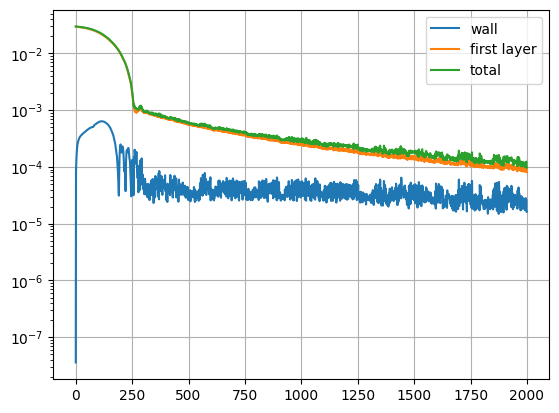

In [60]:
if coarse:
    n_iterations = 2000
else:
    n_iterations = 2000

trained_mesh = training_mesh(None, modified_mesh, boundary_id_list, wall_id_list, first_layer_id_list, coarse=coarse, n_iterations=n_iterations, modified_y_plus=modified_y_plus, target_y_plus=target_y_plus)


In [14]:
## To avoid training in the fine mesh case, run that cell:

#mesh_file = "{}/trained_mesh.su2".format(mesh_dir)
#trained_mesh = torch.tensor(CFD_mesh.read_from_su2Mesh(mesh_file, to_tensor=False))


In [61]:
plot_airfoil_2d_details(trained_mesh, edge_index, trained_mesh[wall_id_list[:, 0]], "test_plot_trained{}".format(text_coarse), first_layer_pts=trained_mesh[first_layer_id_list[:, 0]], coarse=coarse, alpha=beta)
CFD_mesh.write_to_su2Mesh(trained_mesh, "{}/trained_mesh.su2".format(mesh_dir))

'./coarse_mesh/trained_mesh.su2'

In [67]:
!SU2_CFD lam_flatplate_trained.cfg


-------------------------------------------------------------------------
|    ___ _   _ ___                                                      |
|   / __| | | |_  )   Release 8.0.0 "Harrier"                           |
|   \__ \ |_| |/ /                                                      |
|   |___/\___//___|   Suite (Computational Fluid Dynamics Code)         |
|                                                                       |
-------------------------------------------------------------------------
| SU2 Project Website: https://su2code.github.io                        |
|                                                                       |
| The SU2 Project is maintained by the SU2 Foundation                   |
| (http://su2foundation.org)                                            |
-------------------------------------------------------------------------
| Copyright 2012-2023, SU2 Contributors                                 |
|                                    

Text(0, 0.5, 'Y+')

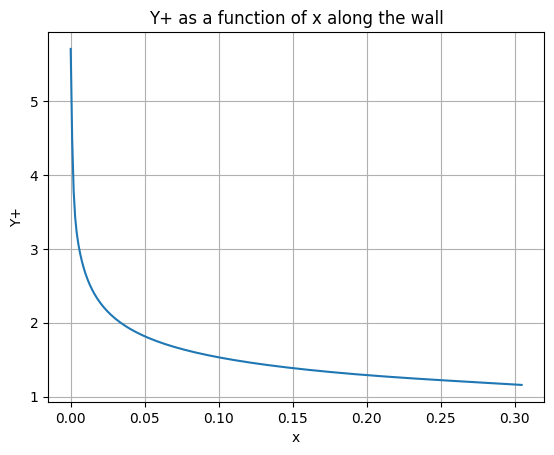

In [68]:
surface_flow_file = "surface_flow{}.vtu".format(text_coarse)
flow_file = "flow{}.vtu".format(text_coarse)

# Load the VTU files
surface_flow_initial = pv.read(surface_flow_file)
flow_initial = pv.read(flow_file)
if len(flow.points)==209825:
    N = 385
    n = 96
    minus = 0
else:
    N = 65
    n = 21
    minus = 1
plt.figure()
plt.plot(flow_initial.points[n*N-minus::N, 0], flow_initial.point_data["Y_Plus"][n*N-minus::N])
plt.grid()
plt.title("Y+ as a function of x along the wall")
plt.xlabel("x")
plt.ylabel("Y+")

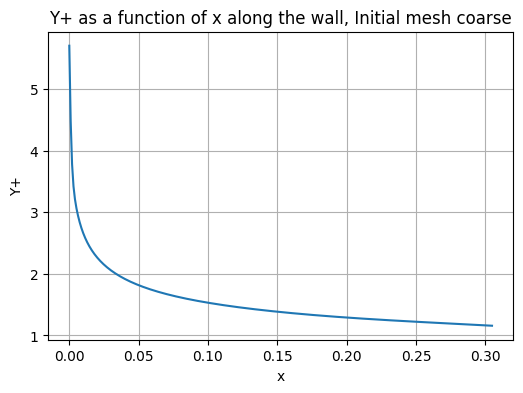

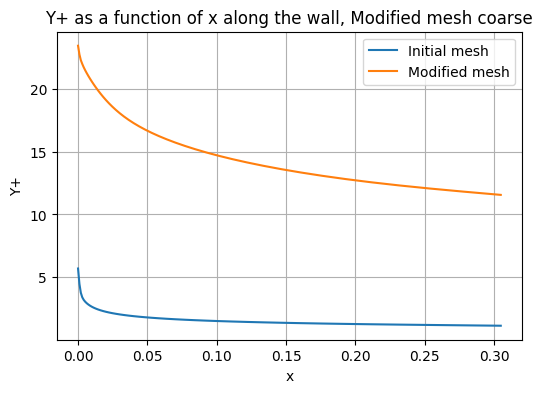

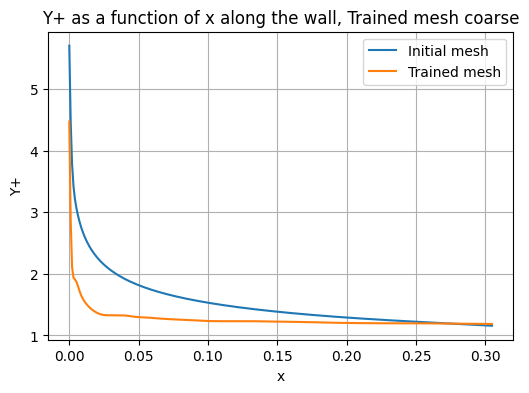

In [69]:

name_file = ["", "_modified", "_trained"]

text_plot = ["Initial mesh", "Modified mesh", "Trained mesh"]
for i, f in enumerate(name_file):
    f = text_coarse+f
    surface_flow_file = "surface_flow{}.vtu".format(f)
    flow_file = "flow{}.vtu".format(f)

    # Load the VTU files
    surface_flow = pv.read(surface_flow_file)
    flow = pv.read(flow_file)
    if len(flow.points)==209825:
        N = 385
        n = 96
        minus = 0
    else:
        N = 65
        n = 21
        minus = 1
    plt.figure(figsize=(6, 4))
    if text_plot[i]!=("Initial mesh"):
        plt.plot(flow_initial.points[n*N-minus::N, 0], flow_initial.point_data["Y_Plus"][n*N-minus::N], label="Initial mesh")
    plt.plot(flow.points[n*N-minus::N, 0], flow.point_data["Y_Plus"][n*N-minus::N], label=text_plot[i])
    plt.grid()
    if coarse:
        plt.title("Y+ as a function of x along the wall, {} coarse".format(text_plot[i]))
    else:
        plt.title("Y+ as a function of x along the wall, {}, fine".format(text_plot[i]))
    if text_plot[i]!=("Initial mesh"):
        plt.legend()


    plt.xlabel("x")
    plt.ylabel("Y+")


Initial mesh : 1.0
Modified mesh : 0.7581004
Trained mesh : 0.9881144


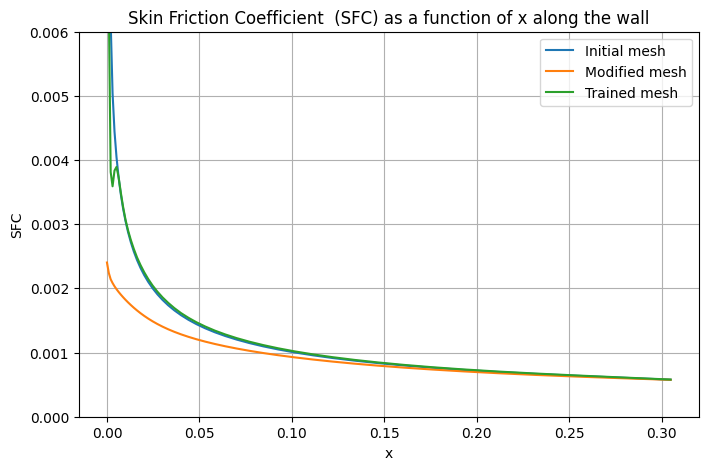

In [70]:
# Create a new figure
plt.figure(figsize=(8, 5))
sfc_initial = np.linalg.norm(flow_initial.point_data["Skin_Friction_Coefficient"][n*N-minus::N], axis=1)

for i, f in enumerate(name_file):
    f = text_coarse+f
    surface_flow_file = "surface_flow{}.vtu".format(f)
    flow_file = "flow{}.vtu".format(f)


    # Load the VTU files
    surface_flow = pv.read(surface_flow_file)
    flow = pv.read(flow_file)

    if len(flow.points)==209825:
        N = 385
        n = 96
        minus = 0
    else:
        N = 65
        n = 21
        minus = 1

    print(text_plot[i], ':', np.mean(np.linalg.norm(flow.point_data["Skin_Friction_Coefficient"][n*N-minus::N], axis=1)/sfc_initial))
    plt.plot(flow.points[n*N-minus::N, 0], np.linalg.norm(flow.point_data["Skin_Friction_Coefficient"][n*N-minus::N], axis=1), label=text_plot[i])


# Add grid, title, and labels
plt.grid()
plt.title("Skin Friction Coefficient  (SFC) as a function of x along the wall")
plt.xlabel("x")
plt.ylabel("SFC")
plt.ylim([0, 0.006])
plt.legend()

# Show the plot
plt.show()


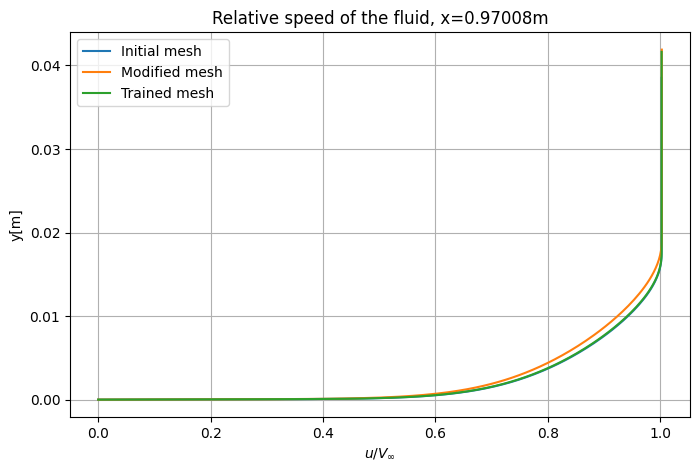

In [19]:
### FOR FINE MESH ###


# Create a new figure
plt.figure(figsize=(8, 5))

# Loop through each folder and plot the data
for i, f in enumerate(name_file):
    f = text_coarse+f
    surface_flow_file = "surface_flow{}.vtu".format(f)
    flow_file = "flow{}.vtu".format(f)

    # Load the VTU files
    surface_flow = pv.read(surface_flow_file)
    flow = pv.read(flow_file)

    N=448
    n=180
    if (name_file[i]=="_modified"):
        n=130
    if (name_file[i]=="_trained"):
        n=130
    V_inf = np.linalg.norm(flow.point_data["Velocity"][200])
    plt.plot(np.linalg.norm(flow.point_data["Velocity"][N*385:N*385+n], axis=1)/V_inf, flow.points[N*385:N*385+n, 1], label=text_plot[i])

# Add grid, title, and labels
plt.title("Relative speed of the fluid, x=0.97008m")
plt.grid()
plt.ylabel("y[m]")
plt.xlabel(r"$u/V_{\infty}$")  # LaTeX formatted xlabel
plt.legend()

# Show the plot
plt.show()

bad mesh -> su2 on bad mesh -> return files with solution -> get array of y+ -> open bad mesh
-> we want all y+ to be 1 -> we scale the first layer by 1/y+ -> we train -> we save the mesh
-> run again and got the results -> analyse results

Show that for two cases 1) coarse mesh with incompressible flow for other model of solver 2) fine mesh with incompressible flow

Strong effect -> extreme case, we want to find the last element where multiplied by 5 times it becomes shitty, and when training is still quite good

Know nothing about scientific computing, explain what's the problem, why we want to solve this problem, background
Prepare for the presentation.
